In [2]:
import pandas as pd
import numpy as np
import shap
from scipy import stats
import sklearn
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from lime.lime_tabular import LimeTabularExplainer
from sklearn.preprocessing import LabelEncoder

In [3]:
df = pd.read_csv("./dataset/credit_card_fraud.csv")

# 0. Data Exploration

In [4]:
df

trans_date_trans_time                   merchant        category  \
0        2019-01-01 00:00:44  Heller, Gutmann and Zieme     grocery_pos   
1        2019-01-01 00:00:51             Lind-Buckridge   entertainment   
2        2019-01-01 00:07:27                  Kiehn Inc     grocery_pos   
3        2019-01-01 00:09:03                Beier-Hyatt    shopping_pos   
4        2019-01-01 00:21:32                 Bruen-Yost        misc_pos   
...                      ...                        ...             ...   
339602   2020-12-31 23:57:56             Schmidt-Larkin            home   
339603   2020-12-31 23:58:04  Pouros, Walker and Spence       kids_pets   
339604   2020-12-31 23:59:07            Reilly and Sons  health_fitness   
339605   2020-12-31 23:59:15                  Rau-Robel       kids_pets   
339606   2020-12-31 23:59:24            Breitenberg LLC          travel   

           amt                      city state      lat      long  city_pop  \
0       107.23                    Orient    WA  48.8878 -118.2105       149   
1       220.11                Malad City    ID  42.1808 -112.2620      4154   
2        96.29                   Grenada    CA  41.6125 -122.5258       589   
3         7.77  High Rolls Mountain Park    NM  32.9396 -105.8189       899   
4         6.85                   Freedom    WY  43.0172 -111.0292       471   
...        ...                       ...   ...      ...       ...       ...   
339602   12.68                     Wales    AK  64.7556 -165.6723       145   
339603   13.02                 Greenview    CA  41.5403 -122.9366       308   
339604   43.77                     Luray    MO  40.4931  -91.8912       519   
339605   86.88                   Burbank    WA  46.1966 -118.9017      3684   
339606    7.99                      Mesa    ID  44.6255 -116.4493       129   

                                      job         dob  \
0       Special educational needs teacher  1978-06-21   
1             Nature conservation officer  1962-01-19   
2                         Systems analyst  1945-12-21   
3                         Naval architect  1967-08-30   
4               Education officer, museum  1967-08-02   
...                                   ...         ...   
339602           Administrator, education  1939-11-09   
339603                Call centre manager  1958-09-20   
339604                       Town planner  1966-02-13   
339605                           Musician  1981-11-29   
339606                       Cartographer  1965-12-15   

                               trans_num  merch_lat  merch_long  is_fraud  
0       1f76529f8574734946361c461b024d99  49.159047 -118.186462         0  
1       a1a22d70485983eac12b5b88dad1cf95  43.150704 -112.154481         0  
2       413636e759663f264aae1819a4d4f231  41.657520 -122.230347         0  
3       8a6293af5ed278dea14448ded2685fea  32.863258 -106.520205         0  
4       f3c43d336e92a44fc2fb67058d5949e3  43.753735 -111.454923         0  
...                                  ...        ...         ...       ...  
339602  a8310343c189e4a5b6316050d2d6b014  65.623593 -165.186033         0  
339603  bd7071fd5c9510a5594ee196368ac80e  41.973127 -123.553032         0  
339604  9b1f753c79894c9f4b71f04581835ada  39.946837  -91.333331         0  
339605  6c5b7c8add471975aa0fec023b2e8408  46.658340 -119.715054         0  
339606  14392d723bb7737606b2700ac791b7aa  44.470525 -117.080888         0  

[339607 rows x 15 columns]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 339607 entries, 0 to 339606
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   trans_date_trans_time  339607 non-null  object 
 1   merchant               339607 non-null  object 
 2   category               339607 non-null  object 
 3   amt                    339607 non-null  float64
 4   city                   339607 non-null  object 
 5   state                  339607 non-null  object 
 6   lat                    339607 non-null  float64
 7   long                   339607 non-null  float64
 8   city_pop               339607 non-null  int64  
 9   job                    339607 non-null  object 
 10  dob                    339607 non-null  object 
 11  trans_num              339607 non-null  object 
 12  merch_lat              339607 non-null  float64
 13  merch_long             339607 non-null  float64
 14  is_fraud               339607 non-nu

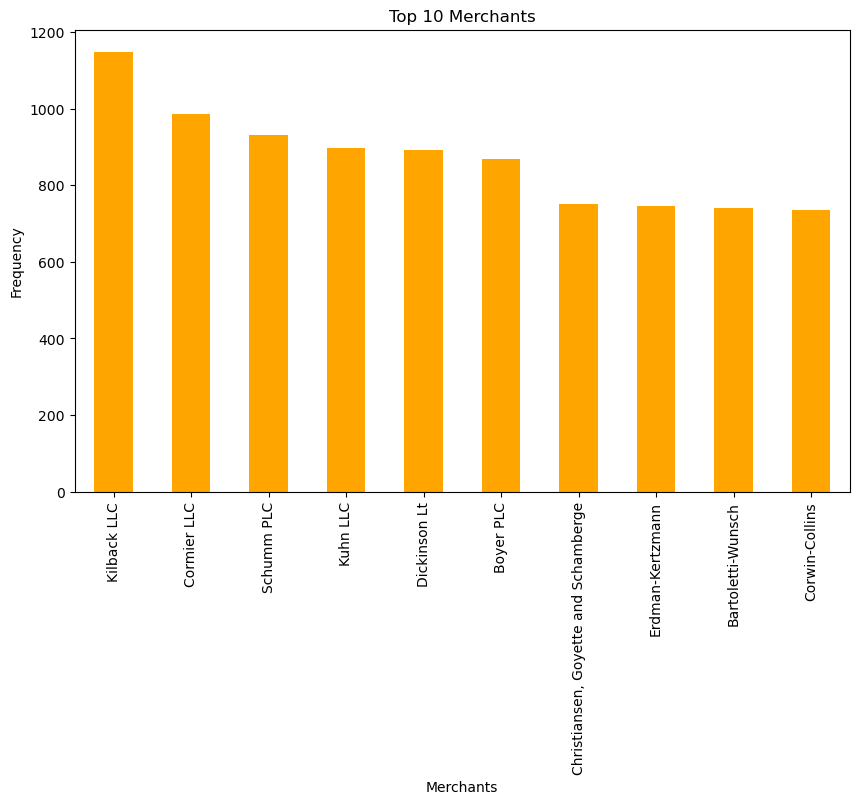

In [6]:
plt.figure(figsize=(10, 6))
top_n = 10  # Adjust to the desired number of top categories to show
df['merchant'].value_counts()[:top_n].plot(kind='bar',color='orange')
plt.xlabel('Merchants')
plt.ylabel('Frequency')
plt.title(f'Top {top_n} Merchants')
plt.show()

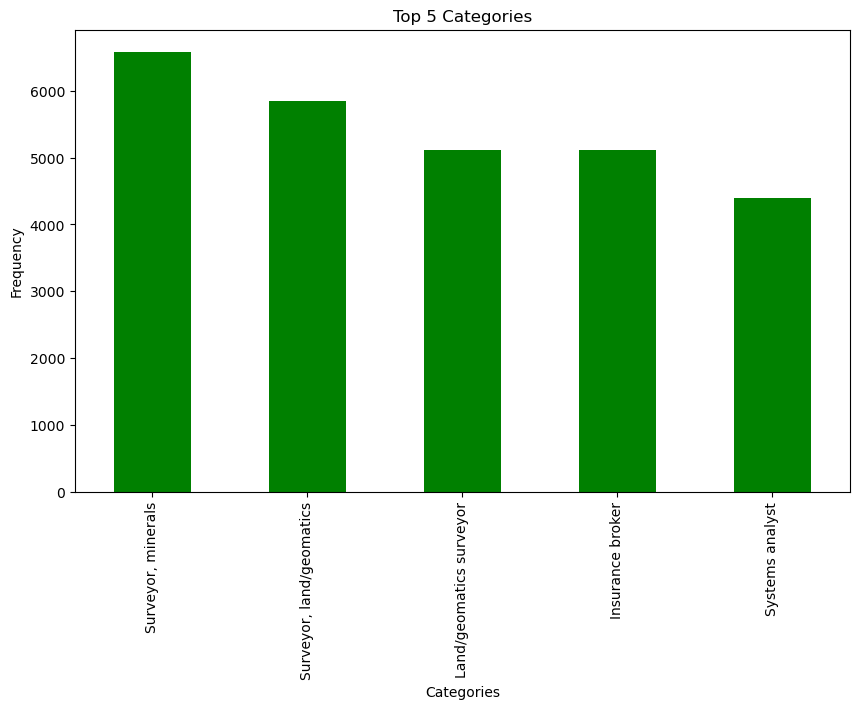

In [7]:
plt.figure(figsize=(10, 6))
top_n = 5  # Adjust to the desired number of top categories to show
df['job'].value_counts()[:top_n].plot(kind='bar', color='green')
plt.xlabel('Categories')
plt.ylabel('Frequency')
plt.title(f'Top {top_n} Categories')
plt.show()

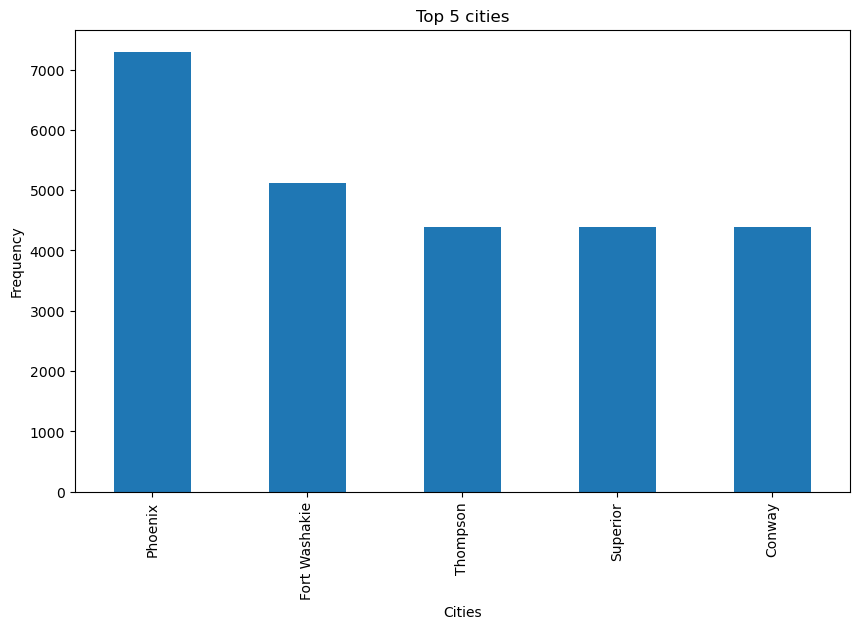

In [8]:
plt.figure(figsize=(10, 6))
top_n = 5  # Adjust to the desired number of top categories to show
df['city'].value_counts()[:top_n].plot(kind='bar')
plt.xlabel('Cities')
plt.ylabel('Frequency')
plt.title(f'Top {top_n} cities')
plt.show()

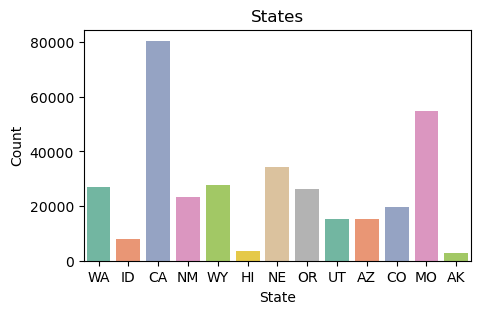

In [9]:
plt.figure(figsize = (5, 3))
sns.countplot(x='state', data=df, palette='Set2')
plt.xlabel('State')
plt.ylabel('Count')
plt.title(f'States')
plt.show()

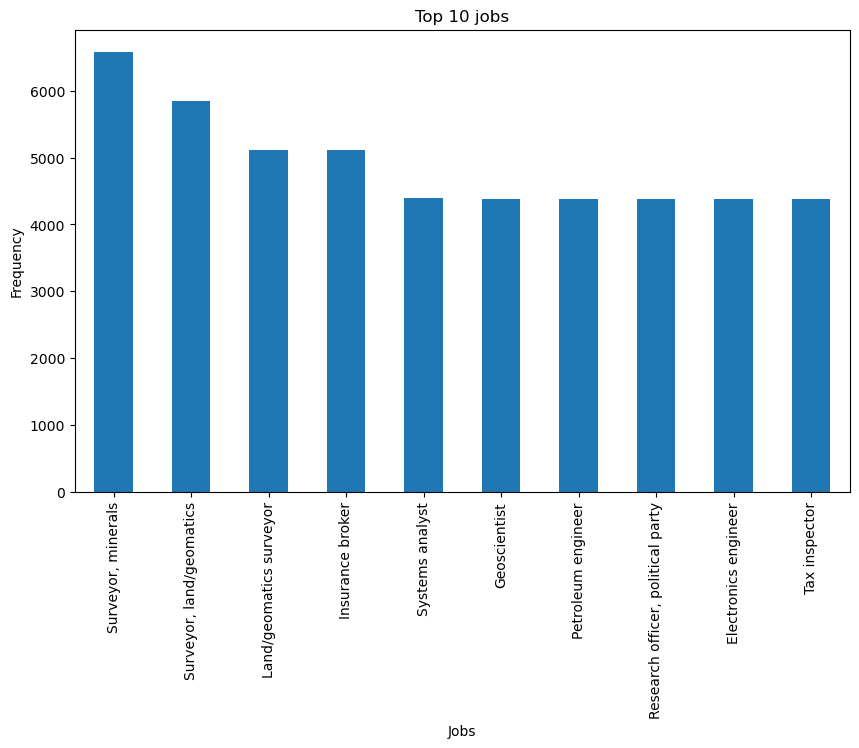

In [10]:
plt.figure(figsize=(10, 6))
top_n = 10  # Adjust to the desired number of top categories to show
df['job'].value_counts()[:top_n].plot(kind='bar')
plt.xlabel('Jobs')
plt.ylabel('Frequency')
plt.title(f'Top {top_n} jobs')
plt.show()

In [11]:
df['is_fraud'].value_counts()

0    337825
1      1782
Name: is_fraud, dtype: int64

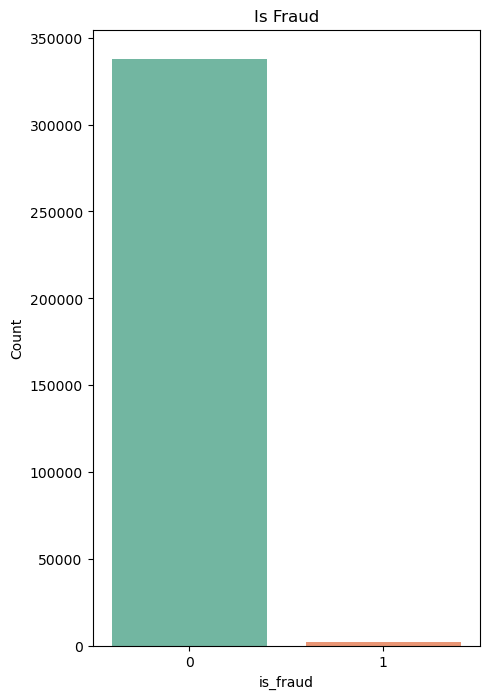

In [12]:
plt.figure(figsize = (5, 8))
sns.countplot(x='is_fraud', data=df, palette='Set2')
plt.xlabel('is_fraud')
plt.ylabel('Count')
plt.title(f'Is Fraud')
plt.show()

# 1. Converting Categorical variables

In [13]:
# Assuming df is your DataFrame and 'categorical_column' is one of the categorical columns
label_encoder = LabelEncoder()

df['merchant_encoded'] = label_encoder.fit_transform(df['merchant'])
df['category_encoded'] = label_encoder.fit_transform(df['category'])
df['city_encoded'] = label_encoder.fit_transform(df['city'])
df['state_encoded'] = label_encoder.fit_transform(df['state'])
df['job_encoded'] = label_encoder.fit_transform(df['job'])
df['trans_num_encoded'] = label_encoder.fit_transform(df['trans_num'])

# 2. Converting dob (date of birth)

In [14]:
# Assuming df is your DataFrame and 'date_of_birth' is the date of birth column
df['dob'] = pd.to_datetime(df['dob'])

current_date = datetime.now()

df['age'] = (current_date - df['dob']).astype('<m8[Y]')

# 3. Converting trans_date_trans_time

In [15]:
# Assuming 'timestamp_column' is the name of your timestamp column
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])

df['trans_date_trans_time_unix'] = df['trans_date_trans_time'].apply(lambda x: x.timestamp())

# 4. Dropping old columns

In [16]:
df.drop(columns=['merchant','category','city','state','job','dob','trans_date_trans_time','trans_num'], axis = 1, inplace = True) \

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 339607 entries, 0 to 339606
Data columns (total 15 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   amt                         339607 non-null  float64
 1   lat                         339607 non-null  float64
 2   long                        339607 non-null  float64
 3   city_pop                    339607 non-null  int64  
 4   merch_lat                   339607 non-null  float64
 5   merch_long                  339607 non-null  float64
 6   is_fraud                    339607 non-null  int64  
 7   merchant_encoded            339607 non-null  int32  
 8   category_encoded            339607 non-null  int32  
 9   city_encoded                339607 non-null  int32  
 10  state_encoded               339607 non-null  int32  
 11  job_encoded                 339607 non-null  int32  
 12  trans_num_encoded           339607 non-null  int32  
 13  age           

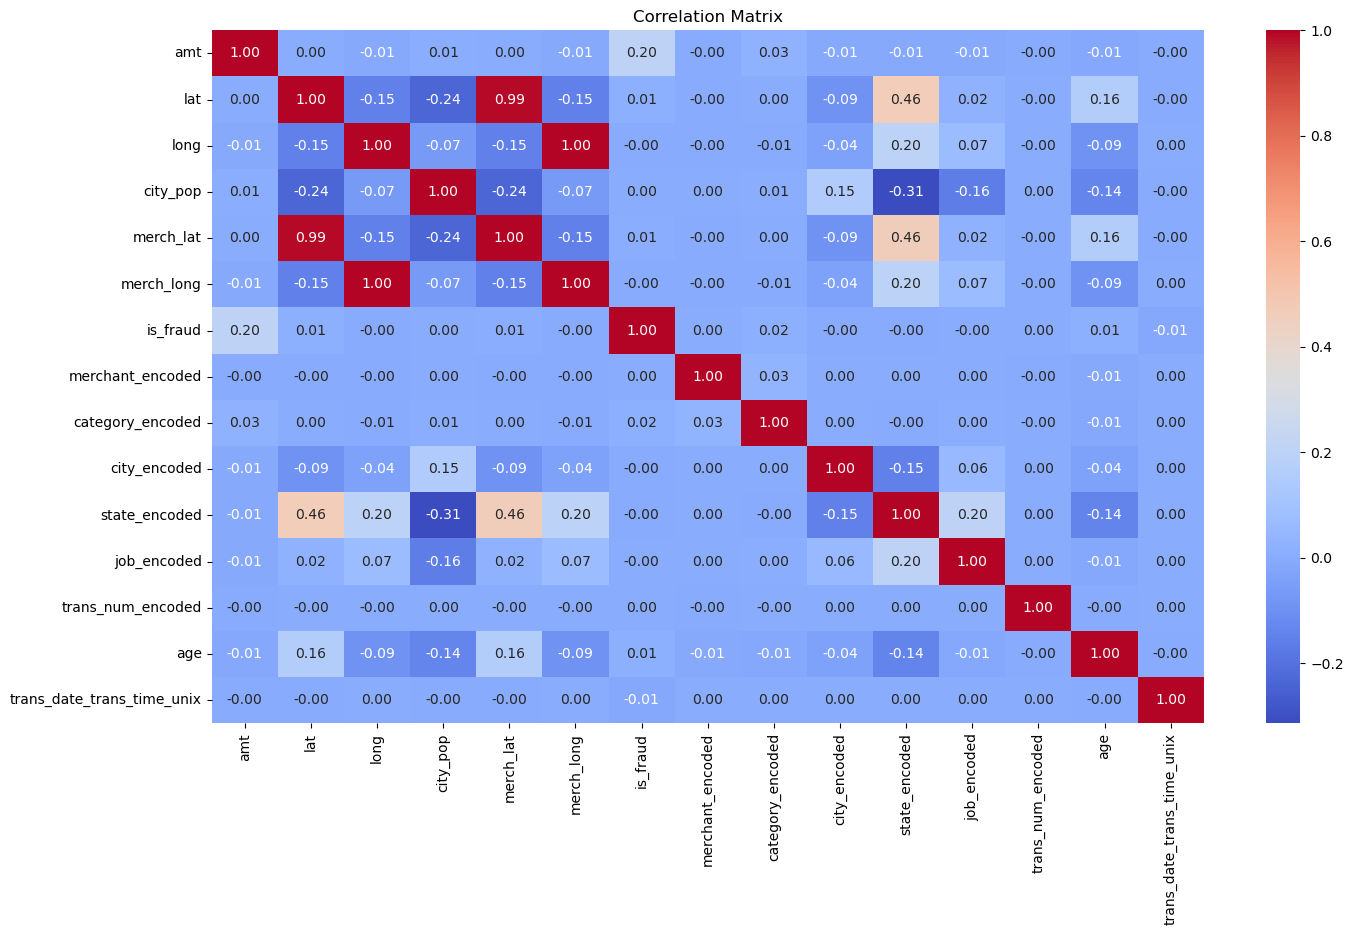

In [17]:
# Assuming you have a DataFrame named 'df' with columns V1 to V28 and 'Class'
correlation_matrix = df.corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(16, 9))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

# XGBoost Classifier

In [18]:
features = ['amt', 'lat', 'long', 'merch_lat', 'merch_long', 'category_encoded', 'city_encoded', 'state_encoded', 'age', 'trans_date_trans_time_unix']

In [19]:
X = df[features]
y = df['is_fraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [20]:
# sum(negative instances) / sum(positive instances)
fraud_cases = df[df['is_fraud'] == 1]
non_fraud_cases = df[df['is_fraud'] == 0]

xgb_scale_pos_weight = len(non_fraud_cases.index) / len(fraud_cases.index)
xgb_scale_pos_weight

189.57631874298542

In [21]:
model_XGB = xgboost.XGBClassifier(n_estimators = 100, max_depth = 2, subsample = 0.7, eta = 0.25, 
                                  scale_pos_weight = xgb_scale_pos_weight, max_delta_step = 1)

In [22]:
model_XGB = model_XGB.fit(X_train, y_train)

In [23]:
y_pred = model_XGB.predict(X_test)

In [96]:
y_pred

array([0, 0, 0, ..., 0, 1, 0])

In [97]:
# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)

# Compute precision
precision = precision_score(y_test, y_pred)

# Compute recall
recall = recall_score(y_test, y_pred)

# Compute F1-score
f1 = f1_score(y_test, y_pred)

# Compute AUC-ROC score
roc_auc = roc_auc_score(y_test, y_pred)  # y_pred_prob should be the predicted probabilities

# Print the accuracy
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"AUC-ROC: {roc_auc:.4f}")

Accuracy: 0.9506
Precision: 0.0937
Recall: 0.9373
F1-score: 0.1703
AUC-ROC: 0.9440


# Global SHAP

In [26]:
explainer = shap.Explainer(model_XGB, X_train)

[21:29:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


In [99]:
shap_values = explainer.shap_values(X_test)

 99%|===================| 67575/67922 [00:45<00:00]        

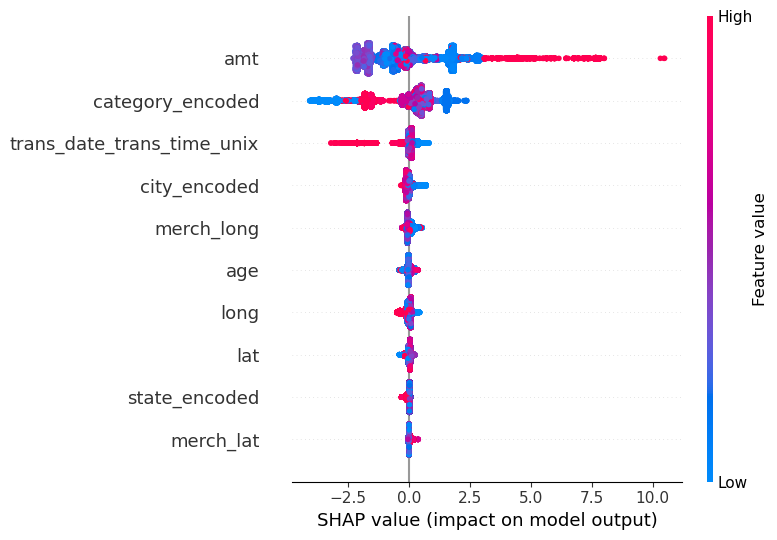

In [100]:
shap.summary_plot(shap_values, X_test, feature_names=features)

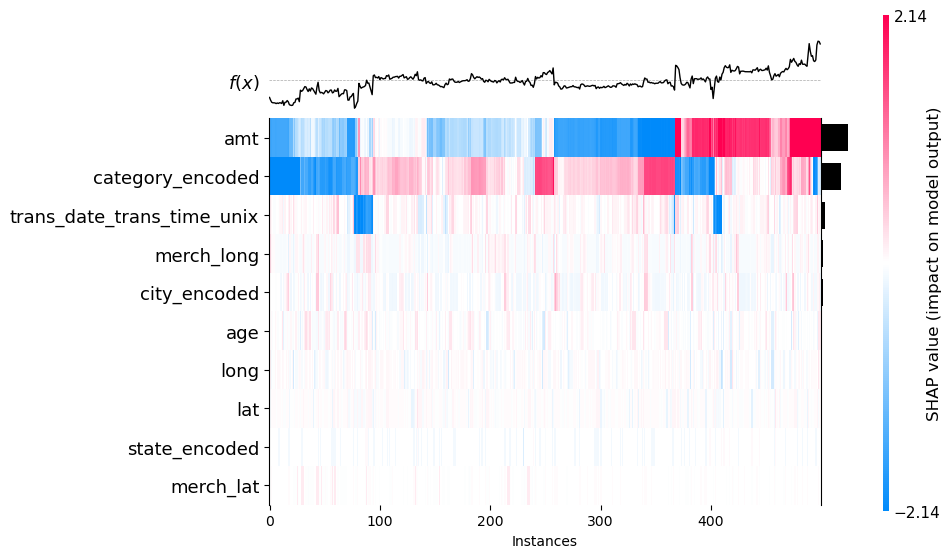

In [101]:
shap_values = explainer(X_test.iloc[:500])
shap.plots.heatmap(shap_values)

# Local SHAP

In [24]:
shap.initjs()

In [27]:
instance_idx = 8

# Explain the model's predictions for instance_idx
shap_values = explainer(X_test.iloc[instance_idx])

# Generate the individual force plot for the selected instance
shap.force_plot(explainer.expected_value, shap_values.values, X_test.iloc[instance_idx])

In [29]:
instance_idx = 64

# Explain the model's predictions for instance_idx
shap_values = explainer(X_test.iloc[instance_idx])

# Generate the individual force plot for the selected instance
shap.force_plot(explainer.expected_value, shap_values.values, X_test.iloc[instance_idx])

# LIME

In [129]:
lime_explainer = LimeTabularExplainer(X_train.values, mode="classification", feature_names=features, class_names=['is_not_fraud','is_fraud'])

In [133]:
instance_idx = 8

# Explain the prediction
explanation = lime_explainer.explain_instance(X_test.values[instance_idx], model_XGB.predict_proba, num_features=len(X_test.columns))

# Visualize the explanation
explanation.show_in_notebook()

In [143]:
instance_idx = 64

# Explain the prediction
explanation = lime_explainer.explain_instance(X_test.values[instance_idx], model_XGB.predict_proba, num_features=len(X_test.columns))

# Visualize the explanation
explanation.show_in_notebook()